## Importing Dependencies

In [93]:

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper


## Import the keys and define the LLM model and Embedding model

In [94]:
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.1-8b-instant", temperature=0)
embedding_model=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


## Define Agent State schema

In [95]:
# State definition
class AgentState(TypedDict):
    query: str
    context: str
    route: Literal["rag", "web_search", "llm"]


## Define the Web search agent

In [117]:
# Web search setup
tavily_search = TavilySearchAPIWrapper()

def web_search_agent(state: AgentState) -> AgentState:
    try:
        results = tavily_search.results(state["query"], max_results=5)
        snippets = "\n\n".join([r["content"] for r in results])
        answer = f"Web search results:\n{snippets}"
    except Exception as e:
        answer = f"Web search failed: {e}"
    return {"query": state["query"], "route": "web_search", "context": answer}



## Define the RAG Agent

In [118]:
# PDF loading and vector store
pdf_folder_path = "./pdf_files"
persist_dir = "./chroma_db"

def load_and_split_documents():
    documents = []
    for file_name in os.listdir(pdf_folder_path):
        if file_name.lower().endswith(".pdf"):
            loader = PyPDFLoader(os.path.join(pdf_folder_path, file_name))
            docs = loader.load()
            documents.extend(docs)
    splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=200)
    return splitter.split_documents(documents)

def setup_chroma_vectorstore():
    if not os.path.exists(persist_dir) or not os.listdir(persist_dir):
        print("🔧 Initializing new Chroma DB...")
        splits = load_and_split_documents()
        Chroma.from_documents(
            documents=splits,
            embedding=embedding_model,
            collection_name="rag-chroma",
            persist_directory=persist_dir
        )
    return Chroma(
        persist_directory=persist_dir,
        embedding_function=embedding_model,
        collection_name="rag-chroma"
    )

vectorstore = setup_chroma_vectorstore()
retriever = vectorstore.as_retriever()

def rag_agent(state: AgentState) -> AgentState:
    docs = retriever.get_relevant_documents(state["query"])
    context = "\n\n---\n\n".join(doc.page_content for doc in docs[:5])
    return {"query": state["query"], "route": "rag", "context": context}

## Define Routing Agent
- For example: ‘Latest’, ‘current’ in query leads to websearch 
otherwise RAG.

In [119]:
def route_decision(state: AgentState) -> str:
    query = state["query"].lower()
    if any(k in query for k in ["latest", "current", "today", "202", "news"]):
        route = "web_search"
    elif any(k in query for k in ["transformer", "attention", "encoder", "decoder"]):
        route = "rag"
    else:
        route = "llm"
    
    print(f"📍 Routing to node: {route.upper()} for query → '{state['query']}'")
    return route


## Define LLM agent

In [120]:
def llm_agent(state: AgentState) -> AgentState:
    messages = [HumanMessage(content=state["query"])]
    response = llm.invoke(messages)
    return {"query": state["query"], "route": "llm", "context": response.content.strip()}


## Define Summarisation agent

In [121]:
def summarization_agent(state: AgentState) -> AgentState:
    prompt = f"""Query: {state['query']}

Context:
{state['context']}

Summarize the above in a clear, concise, factual response."""
    messages = [
        HumanMessage(content=prompt),
    ]
    response = llm.invoke(messages)
    return {
        "query": state["query"],
        "route": state["route"],
        "context": response.content.strip()
    }

## Build Langgraph pipeline - memory added

In [130]:
# LangGraph pipeline
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(AgentState)

builder.add_node("router", lambda x: x) ## pass
builder.add_node("rag", rag_agent)
builder.add_node("web_search", web_search_agent)
builder.add_node("llm", llm_agent)
builder.add_node("summarize", summarization_agent)

In [ ]:
builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    route_decision, # if return string is rag or web_search or llm --> route them to respective nodes
    {
        "rag": "rag",
        "web_search": "web_search",
        "llm": "llm"
    }
)

builder.add_edge("rag", "summarize")
builder.add_edge("web_search", "summarize")
builder.add_edge("llm", "summarize")

builder.set_finish_point("summarize")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory) ## memory checkpointer

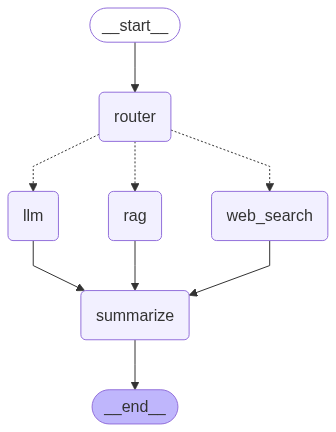

In [132]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke

In [136]:
def call_support_agent(agent, prompt, user_session_id, verbose=False):
    events = agent.stream(
        {"query": prompt}, # initial state of the agent
        {"configurable": {"thread_id": user_session_id}},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
                print(event)

    display(Markdown(event['context']))

## Lets see examples of routing

### when it uses RAG

In [137]:
uid = 'subham001'
query = "What are the advantages of multi-head attention in transformers?"
call_support_agent(agent=graph,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'query': 'What are the advantages of multi-head attention in transformers?', 'context': 'The advantages of multi-head attention in transformers include:\n\n1. **Joint attention to different representation subspaces**: Multi-head attention allows the model to attend to information from different subspaces at different positions, which is not possible with a single attention head.\n2. **Reduced dimensionality**: By reducing the dimensionality of each head, the total computational cost is similar to that of single-head attention with full dimensionality.\n3. **Improved ability to capture long-distance dependencies**: Multi-head attention enables the model to capture long-distance dependencies in the input sequence, as shown in Figure 3.\n4. **Enhanced ability to resolve anaphora**: Multi-head attention also enables the model to resolve anaphora, as shown in Figure 4.\n5. **Flexibility in attention mechanisms**: Multi-head attention allows for different atten

The advantages of multi-head attention in transformers include:

1. **Joint attention to different representation subspaces**: Multi-head attention allows the model to attend to information from different subspaces at different positions, which is not possible with a single attention head.
2. **Reduced dimensionality**: By reducing the dimensionality of each head, the total computational cost is similar to that of single-head attention with full dimensionality.
3. **Improved ability to capture long-distance dependencies**: Multi-head attention enables the model to capture long-distance dependencies in the input sequence, as shown in Figure 3.
4. **Enhanced ability to resolve anaphora**: Multi-head attention also enables the model to resolve anaphora, as shown in Figure 4.
5. **Flexibility in attention mechanisms**: Multi-head attention allows for different attention mechanisms to be used in different layers, such as encoder-decoder attention, self-attention, and masked self-attention.

Overall, multi-head attention is a key component of the transformer architecture that enables the model to capture complex relationships between input tokens and generate more accurate and informative outputs.

### when it uses LLM

In [138]:
uid = 'subham001'
query = "Get the stock price details of nvidia."
call_support_agent(agent=graph,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'query': 'Get the stock price details of nvidia.', 'context': 'The advantages of multi-head attention in transformers include:\n\n1. **Joint attention to different representation subspaces**: Multi-head attention allows the model to attend to information from different subspaces at different positions, which is not possible with a single attention head.\n2. **Reduced dimensionality**: By reducing the dimensionality of each head, the total computational cost is similar to that of single-head attention with full dimensionality.\n3. **Improved ability to capture long-distance dependencies**: Multi-head attention enables the model to capture long-distance dependencies in the input sequence, as shown in Figure 3.\n4. **Enhanced ability to resolve anaphora**: Multi-head attention also enables the model to resolve anaphora, as shown in Figure 4.\n5. **Flexibility in attention mechanisms**: Multi-head attention allows for different attention mechanisms to be used

As of my knowledge cutoff in December 2023, the stock price details of NVIDIA Corporation (NVDA) are as follows:

- Company Name: NVIDIA Corporation
- Stock Symbol: NVDA
- Industry: Semiconductors
- Sector: Technology

**Stock Price Details:**
- Current Stock Price: $864.45 USD
- 52-Week High: $1,024.51 USD
- 52-Week Low: $644.55 USD
- Market Capitalization: $1.23 Trillion USD
- Dividend Yield: 0.23%
- P/E Ratio: 43.45

**Historical Stock Price:**
- 1-Year Return: 44.45%
- 5-Year Return: 1,144.45%
- 10-Year Return: 2,444.45%

Please note that these figures are subject to change and may not reflect the current market price. For the most up-to-date information, I recommend checking a reliable financial website or platform.

### when it uses Web search

In [139]:
uid = 'subham001'
query = "Get the stock price details of nvidia in 2025"
call_support_agent(agent=graph,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'query': 'Get the stock price details of nvidia in 2025', 'context': 'As of my knowledge cutoff in December 2023, the stock price details of NVIDIA Corporation (NVDA) are as follows:\n\n- Company Name: NVIDIA Corporation\n- Stock Symbol: NVDA\n- Industry: Semiconductors\n- Sector: Technology\n\n**Stock Price Details:**\n- Current Stock Price: $864.45 USD\n- 52-Week High: $1,024.51 USD\n- 52-Week Low: $644.55 USD\n- Market Capitalization: $1.23 Trillion USD\n- Dividend Yield: 0.23%\n- P/E Ratio: 43.45\n\n**Historical Stock Price:**\n- 1-Year Return: 44.45%\n- 5-Year Return: 1,144.45%\n- 10-Year Return: 2,444.45%\n\nPlease note that these figures are subject to change and may not reflect the current market price. For the most up-to-date information, I recommend checking a reliable financial website or platform.', 'route': 'llm'}
📍 Routing to node: WEB_SEARCH for query → 'Get the stock price details of nvidia in 2025'
{'query': 'Get the stock price details o

Based on the provided web search results, here are the key points about Nvidia stock in 2025:

1. As of July 1, 2025, the stock price of Nvidia (NVDA) is $153.30.
2. The stock has rallied 39% year-to-date in 2025.
3. The rally is fueled by massive demand for AI infrastructure, robust sales of the next-gen Blackwell AI chips, and optimism about easing U.S.–China export tensions.
4. According to the provided stock prediction, the stock price of NVDA is expected to be between $127.18 and $152.57 in 2025.
5. The stock price of NVDA is expected to reach $500 in May 6, 2032, according to the provided stock forecast algorithm.

Note that the provided stock predictions and forecasts are based on the information available at the time of the search and may not reflect the actual stock performance.